## Test Stable video diffusion

- Link: https://huggingface.co/docs/diffusers/using-diffusers/svd
- Model: https://huggingface.co/stabilityai/stable-video-diffusion-img2vid-xt
- Note that it is research only, and not commercial license

### Sample generation

- First, generate image using SDXL (uses bedrock here)
- Second, generate video using SVD-XL
- SVD-XL can be run on `g4dn.xlarge` with `fp16`. But have an issue at LMI DLC so used `g5.xlarge`. (Need to check how to run on g4dn)


In [ ]:
!pip install -q diffusers transformers accelerate

In [ ]:
# !pip list | grep diffusers

In [5]:
import sagemaker
import transformers
import diffusers
print(sagemaker.__version__)
print(transformers.__version__)
print(diffusers.__version__)

2.207.1
4.37.2
0.26.3


In [ ]:
from huggingface_hub import snapshot_download
from pathlib import Path
import os

local_model_path = Path("./pretrained-models")
local_model_path.mkdir(exist_ok=True)
model_name = "stabilityai/stable-video-diffusion-img2vid-xt"
allow_patterns = ["*.json", "*.pt", "*.bin", "*.txt", "*.model", "*.py", "*.safetensors"]

model_download_path = snapshot_download(
    repo_id=model_name,
    cache_dir=local_model_path,
    allow_patterns=allow_patterns,
)

In [ ]:
model_download_path = "pretrained-models/models--stabilityai--stable-video-diffusion-img2vid-xt/snapshots/a1ce917313331d9d6cdea065aa176c27198bcaad"
print(f"Local model download path: {model_download_path}")

In [ ]:
import torch
import random

from diffusers import StableVideoDiffusionPipeline
from diffusers.utils import load_image, export_to_video

with_unet_compile = False

pipe = StableVideoDiffusionPipeline.from_pretrained(
    model_download_path, torch_dtype=torch.float16, variant="fp16"
)

if with_unet_compile:
    # Need pytorch 2.2
    # refer to https://github.com/huggingface/diffusers/issues/6096
    pipe.to("cuda")
    pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)
else:
    pipe.enable_model_cpu_offload()


In [6]:
import boto3
import json
import io
import base64
from PIL import Image

In [7]:
bedrock_client = boto3.client("bedrock-runtime")

In [8]:
def image_generation_sdxl(query, preset=None):

    prompt = query
    negative_prompts = [
        "poorly rendered",
        "poor background details",
        "worst quality",
        "low quality"
    ]
    
    width = 1344
    height = 768
    request_data = {
        "text_prompts": (
            [{"text": prompt, "weight": 1.0}]
            + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
        ),
        "cfg_scale": 25,
        "seed": 0,
        "steps": 50,
        "width": width,
        "height": height,
    }

    if preset is not None:
        request_data["style_preset"] = preset

    request = json.dumps(request_data)
    modelId = "stability.stable-diffusion-xl-v1"

    response = bedrock_client.invoke_model(body=request, modelId=modelId)
    response_body = json.loads(response.get("body").read())
    base_64_img_str = response_body["artifacts"][0].get("base64")
    image = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
    return image

In [9]:
prompt = "A cute cat with big eyes is playing on Mars"
generated_img = image_generation_sdxl(prompt)

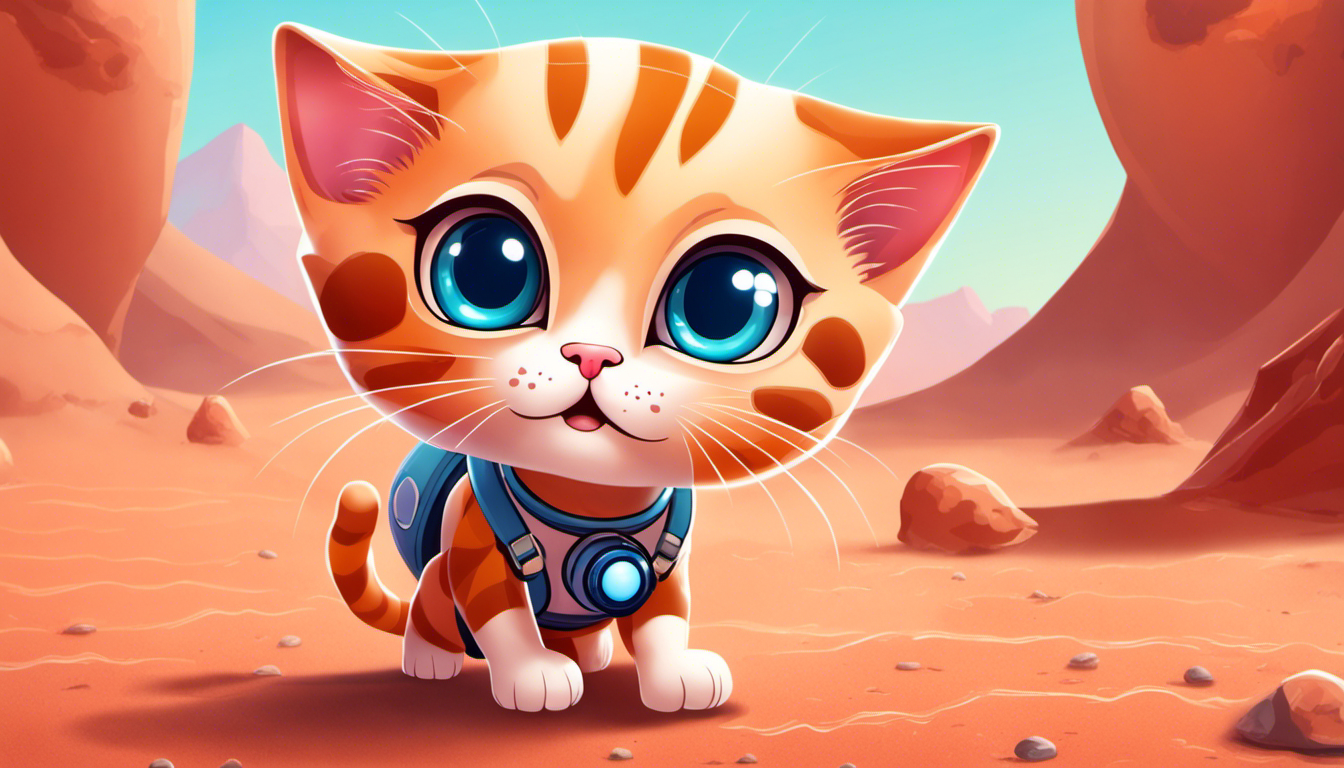

In [10]:
generated_img

In [ ]:
%%time

# Load the conditioning image
# image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/svd/rocket.png")
image = generated_img.resize((1024, 576))

generator = torch.manual_seed(random.randint(0,999999))
frames = pipe(image, decode_chunk_size=8, generator=generator).frames[0]

export_to_video(frames, "generated.mp4", fps=7)

## Deploy SVD-XL on SageMaker endpoint using LMI DLC

- It takes long time to process, need to use async endpoint

In [ ]:
s3_model_prefix = "llm/stabilityai/model"  # folder where model checkpoint will go

In [ ]:
base_model_s3 = f"{s3_model_prefix}/svd-xl"

In [ ]:
sagemaker_session = sagemaker.Session()
# s3_model_artifact = sagemaker_session.upload_data(path=model_download_path, key_prefix=base_model_s3)

In [ ]:
s3_model_artifact = "s3://sagemaker-us-west-2-723597067299/llm/stabilityai/model/svd-xl/"
print(f"Model s3 uri : {s3_model_artifact}")

### Local LMI DLC test

- Check the `local_lmi_endpoint.sh`

In [ ]:
import requests

endpoint = "http://127.0.0.1:8080/invocations"

data = {
    "input_image_s3": "s3://seso-developers/workspace/aiml/stable-diffusion/samples/rocket.png",
    "upload_s3_bucket": "sagemaker-us-west-2-723597067299",
    "parameters": {}
}

headers = {"content-type": "application/json"}
output = requests.post(endpoint, headers=headers, json=data)

print(output)

### Deploy it on SageMaker endpoint

- It takes long time, therefore need to deploy as a async endpoint

In [11]:
import boto3
import sagemaker
from sagemaker.utils import name_from_base
from sagemaker import image_uris

In [12]:
llm_engine = "deepspeed"
# llm_engine = "fastertransformer"

In [32]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
sm_client = sagemaker_session.sagemaker_client
sm_runtime_client = sagemaker_session.sagemaker_runtime_client
s3_client = boto3.client('s3')
default_bucket = sagemaker_session.default_bucket()

In [44]:
import io
s3_client = boto3.client("s3")

def upload_image_to_s3(bucket_name, object_key, image):
    # Create an in-memory file object
    with io.BytesIO() as buffer:
        image.save(buffer, "png")
        buffer.seek(0)

        try:
            s3_client.upload_fileobj(buffer, bucket_name, object_key)
            return True
        except Exception as e:
            raise RuntimeError(f"Error uploading image: {e}") from e

    return False

In [45]:
import uuid

file_name = str(uuid.uuid4()) + ".png"
obj_key = f"svd-xl/input-samples/{file_name}"
if upload_image_to_s3(default_bucket, obj_key, generated_img):
    upload_url = f"s3://{default_bucket}/{obj_key}"
    print(f"Succeed to upload file on s3: {upload_url}")
else:
    print("Failed to upload !!")

print(upload_url)

Succeed to upload file on s3: s3://sagemaker-us-west-2-723597067299/svd-xl/input-samples/9d87badc-e5be-489c-b0d8-1c3c19c0ce20.png
s3://sagemaker-us-west-2-723597067299/svd-xl/input-samples/9d87badc-e5be-489c-b0d8-1c3c19c0ce20.png


In [14]:
framework_name = f"djl-{llm_engine}"
inference_image_uri = image_uris.retrieve(
    framework=framework_name, region=sagemaker_session.boto_session.region_name, version="0.23.0"
)

print(f"Inference container uri: {inference_image_uri}")

Inference container uri: 763104351884.dkr.ecr.us-west-2.amazonaws.com/djl-inference:0.23.0-deepspeed0.9.5-cu118


In [15]:
s3_target = f"s3://{sagemaker_session.default_bucket()}/llm/stabilityai/svd-xl/code/"
print(s3_target)

s3://sagemaker-us-west-2-723597067299/llm/stabilityai/svd-xl/code/


In [16]:
local_src_path = "svd-xl-src"

In [17]:
!rm {local_src_path}.tar.gz
!tar zcvf {local_src_path}.tar.gz {local_src_path} --exclude ".ipynb_checkpoints" --exclude "__pycache__"
!aws s3 cp {local_src_path}.tar.gz {s3_target}

svd-xl-src/
svd-xl-src/model.py
svd-xl-src/requirements.txt
svd-xl-src/serving.properties
upload: ./svd-xl-src.tar.gz to s3://sagemaker-us-west-2-723597067299/llm/stabilityai/svd-xl/code/svd-xl-src.tar.gz


In [18]:
model_uri = f"{s3_target}{local_src_path}.tar.gz"
print(model_uri)

s3://sagemaker-us-west-2-723597067299/llm/stabilityai/svd-xl/code/svd-xl-src.tar.gz


In [19]:
model_name = name_from_base(f"svd-xl-djl")
print(model_name)

create_model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={"Image": inference_image_uri, "ModelDataUrl": model_uri},
)
model_arn = create_model_response["ModelArn"]

print(f"Created Model: {model_arn}")

svd-xl-djl-2024-02-19-01-28-45-312
Created Model: arn:aws:sagemaker:us-west-2:723597067299:model/svd-xl-djl-2024-02-19-01-28-45-312


In [20]:
default_bucket = sagemaker_session.default_bucket()
async_output_uri = f"s3://{default_bucket}/llm/outputs/{model_name}/"
print(async_output_uri)

s3://sagemaker-us-west-2-723597067299/llm/outputs/svd-xl-djl-2024-02-19-01-28-45-312/


In [21]:
# instance_type = "ml.g5.2xlarge"
instance_type = "ml.g5.xlarge"

# Locally testing model on g4dn is okay but exception caused at LMI DLC.
# instance_type = "ml.g4dn.xlarge"

endpoint_config_name = f"{model_name}-async-config"
endpoint_name = f"{model_name}-async-endpoint"

endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": instance_type,
            "InitialInstanceCount": 1,
            "ContainerStartupHealthCheckTimeoutInSeconds": 600,
        },
    ],
    AsyncInferenceConfig={
        "OutputConfig": {
            "S3OutputPath": async_output_uri,
        },
        "ClientConfig": {
            "MaxConcurrentInvocationsPerInstance": 1
        }
    }
)
print(endpoint_config_response)

{'EndpointConfigArn': 'arn:aws:sagemaker:us-west-2:723597067299:endpoint-config/svd-xl-djl-2024-02-19-01-28-45-312-async-config', 'ResponseMetadata': {'RequestId': '28e41610-e60c-49e1-908d-9dfc5ee405aa', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '28e41610-e60c-49e1-908d-9dfc5ee405aa', 'content-type': 'application/x-amz-json-1.1', 'content-length': '128', 'date': 'Mon, 19 Feb 2024 01:28:46 GMT'}, 'RetryAttempts': 0}}


In [22]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=f"{endpoint_name}", EndpointConfigName=endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

Created Endpoint: arn:aws:sagemaker:us-west-2:723597067299:endpoint/svd-xl-djl-2024-02-19-01-28-45-312-async-endpoint


In [23]:
import time

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-west-2:723597067299:endpoint/svd-xl-djl-2024-02-19-01-28-45-312-async-endpoint
Status: InService


In [48]:
import json

In [49]:
payload = {
    "input_image_s3": upload_url,
    "upload_s3_bucket": default_bucket,
    "parameters": {}
}

In [50]:
# Upload input data onto the S3
s3_uri = f"llm/inputs/{model_name}/{uuid.uuid4()}.json"
s3_client.put_object(
    Bucket=default_bucket,
    Key=s3_uri,
    Body=json.dumps(payload))

input_data_uri = f"s3://{default_bucket}/{s3_uri}"
input_location = input_data_uri

In [51]:
response = sm_runtime_client.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=input_location,
    ContentType="application/json"
)
output_location = response["OutputLocation"]
print(output_location)
output_key_uri = "/".join(output_location.split("/")[3:])

s3://sagemaker-us-west-2-723597067299/llm/outputs/svd-xl-djl-2024-02-19-01-28-45-312/d4bd22a8-8f12-4a97-b785-d32ed8063ad7.out


In [52]:
time_count = 0
max_min_time = 10

while time_count < max_min_time:
    try:
        exists = s3_client.head_object(Bucket=default_bucket, Key=output_key_uri)['ResponseMetadata']['HTTPStatusCode'] == 200
        if exists:
            text_obj = s3_client.get_object(Bucket=default_bucket, Key=output_key_uri)['Body'].read()
            text = text_obj.decode('utf-8')
            print(text)
            break
    except:
        print("Data is not exist yet. Wait until inference finished ...")
    
    time.sleep(60)
    time_count += 1

Data is not exist yet. Wait until inference finished ...
Data is not exist yet. Wait until inference finished ...
Data is not exist yet. Wait until inference finished ...
{
  "s3_path":"s3://sagemaker-us-west-2-723597067299/svd-xl/svd-xl-output/500d8508-e9df-443d-afad-57a6ee65e22d.mp4"
}


In [53]:
print(text)

{
  "s3_path":"s3://sagemaker-us-west-2-723597067299/svd-xl/svd-xl-output/500d8508-e9df-443d-afad-57a6ee65e22d.mp4"
}
